We're adding some new packages now!

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

# this is to make figures show up in the notebook; otherwise they will have to be saved as images and viewed outside
%matplotlib inline 

First, we need to read in the data.

In [3]:
df = pd.read_csv('./fulldata_210818.csv')
df.head()

,Unnamed: 0,speaker,recording,year,topic,VowelN,t1,t2,timetoIPend,VowelQ,vstress,word,wstress,VoiceQ,hnr_mid,hnr_mean,f0_mid,f0_mean,duration,center
0,0,S01,10_12_21_tipicas_107,2010,same topic,5,7.298978,7.385666,0.983432,a,2_pre_n,ordenanzas,NaN,NaN,10.161777,8.484151,147.571671,147.926991,0.086688,7.342322
1,1,S01,10_12_21_tipicas_107,2010,same topic,4,7.513118,7.582061,0.769292,a,1_pre_n,ordenanzas,NaN,NaN,10.380362,7.725520,142.517535,145.851500,0.068943,7.547590
2,2,S01,10_12_21_tipicas_107,2010,same topic,3,7.702022,7.759934,0.580388,i,n,típicas,antepenultimate,NaN,13.024623,9.455524,133.019083,133.992925,0.057912,7.730978
3,3,S01,10_12_21_tipicas_107,2010,same topic,2,7.795915,7.863479,0.486495,i,1_post_n,típicas,antepenultimate,NaN,-200.000000,NaN,NaN,NaN,0.067564,7.829697
4,4,S01,10_12_21_tipicas_107,2010,same topic,1,7.957242,8.055141,0.325168,a,2_post_n,típicas,antepenultimate,whisper,-178.122895,5.083245,NaN,NaN,0.097899,8.006191


Notice that there are quite a lot of NaNs! These stand for 'not a number' and can mean a variety of different things. For numerical data (e.g. hnr and f0 values), it usually means that it couldn't be calculated at this point, possibly due to there being no voicing. For text fields, it usually means that the field was empty when read in. The next few cells are an attempt to deal with them.

First, the NaNs that appear in the hnr_mean field most likely should simply be treated as the most whispered/negative value there is. One way to handle this is to find the min value for this column and replace all NaNs in this column with it.

In [5]:
nanvalue = min(df.hnr_mean)
df.hnr_mean = df.hnr_mean.apply(lambda x: nanvalue if np.isnan(x) else x)
df.head()

,Unnamed: 0,speaker,recording,year,topic,VowelN,t1,t2,timetoIPend,VowelQ,vstress,word,wstress,VoiceQ,hnr_mid,hnr_mean,f0_mid,f0_mean,duration,center
0,0,S01,10_12_21_tipicas_107,2010,same topic,5,7.298978,7.385666,0.983432,a,2_pre_n,ordenanzas,NaN,NaN,10.161777,8.484151,147.571671,147.926991,0.086688,7.342322
1,1,S01,10_12_21_tipicas_107,2010,same topic,4,7.513118,7.582061,0.769292,a,1_pre_n,ordenanzas,NaN,NaN,10.380362,7.725520,142.517535,145.851500,0.068943,7.547590
2,2,S01,10_12_21_tipicas_107,2010,same topic,3,7.702022,7.759934,0.580388,i,n,típicas,antepenultimate,NaN,13.024623,9.455524,133.019083,133.992925,0.057912,7.730978
3,3,S01,10_12_21_tipicas_107,2010,same topic,2,7.795915,7.863479,0.486495,i,1_post_n,típicas,antepenultimate,NaN,-200.000000,-3.899103,NaN,NaN,0.067564,7.829697
4,4,S01,10_12_21_tipicas_107,2010,same topic,1,7.957242,8.055141,0.325168,a,2_post_n,típicas,antepenultimate,whisper,-178.122895,5.083245,NaN,NaN,0.097899,8.006191


For VoiceQ, we want to replace all NaNs with 'modal'. (THings to think about: what would you do for wstress and f0?)

In [8]:
df[['VoiceQ']] = df[['VoiceQ']].fillna(value='modal')

Notice though, that even after this fix, there are some anomalous entries in VoiceQ! Let's fix them.

In [9]:
df.VoiceQ.unique()

array(['modal', 'whisper', 'creaky', 'whisper?', ' whisper'], dtype=object)

In [10]:
df.VoiceQ = df.VoiceQ.apply(lambda x: 'whisper' if (x=='whisper?' or x==' whisper') else x)
df.VoiceQ.unique()

array(['modal', 'whisper', 'creaky'], dtype=object)

And now let's combine the early years together into the same grouping. We'll create a new column, 'era'.

In [14]:
df.year.unique()

array([2010, 2021, 2000, 1993, 1998, 2001])

In [16]:
df['era'] = df.year.apply(lambda x: 'early' if x<2010 else ('mid' if x==2010 else 'late'))

Time to look at the data and try to answer some questions!

**Question 1. Can HNR values distinguish between whispered and modal tokens?**

Let's look at the distribution of the HNR values in a histogram or density plot! If there is a clear bimodal distribution, *and* all of the values on one side are labelled one way and values on the other side are labelled the other way, that's a good sign.

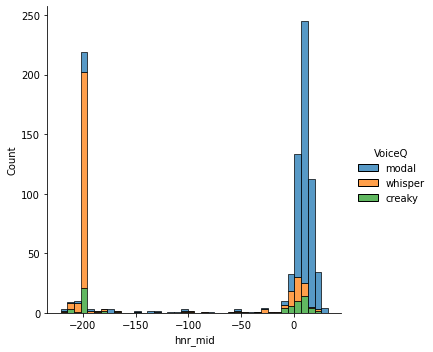

In [26]:
sns.displot(data=df, x='hnr_mid', hue='VoiceQ', multiple='stack', bins=40)

From these figures, we can see that indeed HNR looks pretty well split between modal and whisper VQ (with creaky voice scattered around too). It would be a good idea to have a look at the items where HNR > 0 but were classified as 'whisper', and vice versa, just to see what's going on. The existence of these items doesn't make HNR a bad measure necessarily. I could simply be that some of the items were ambiguous.

In [21]:
df[(df.VoiceQ=='whisper') & (df.hnr_mid > 0)]

,Unnamed: 0,speaker,recording,year,topic,VowelN,t1,t2,timetoIPend,VowelQ,...,word,wstress,VoiceQ,hnr_mid,hnr_mean,f0_mid,f0_mean,duration,center,era
8,3,S01,21_05_10_sagunto_275,2021,same topic,2,5.934391,6.004315,0.336192,u,...,sagunto,penultimate,whisper,18.645776,-1.506311,NaN,114.559489,0.069924,5.969353,late
33,3,S01,21_05_10_distubios_271,2021,same topic,2,14.300103,14.349354,0.440741,u,...,distubios,penultimate,whisper,9.493395,5.320485,87.834840,88.683582,0.049251,14.324728,late
49,3,S01,21_06_14_esperar_61,2021,new topic,2,10.275948,10.327573,0.211193,e,...,esperar,ultimate,whisper,6.066329,7.697757,145.228014,148.300435,0.051624,10.301761,late
50,4,S01,21_06_14_esperar_61,2021,new topic,1,10.349589,10.461332,0.137552,a,...,esperar,ultimate,whisper,10.080069,6.734064,189.107287,179.779061,0.111743,10.405460,late
59,3,S01,21_07_06_diario_122,2021,new topic,2,8.233676,8.362638,0.323642,ia,...,diario,penultimate,whisper,2.104560,2.288095,151.819592,154.016784,0.128961,8.298157,late
74,3,S01,10_12_21_seno_106,2010,adjacent topic,2,9.539934,9.621510,0.246423,e,...,seno*,penultimate,whisper,3.857790,2.163318,132.701260,132.975376,0.081577,9.580722,mid
80,4,S01,21_07_12_sanchez_202,2021,adjacent topic,1,9.816243,9.925938,0.287777,e,...,Sanchez,penultimate,whisper,19.632699,1.312294,NaN,NaN,0.109695,9.871090,late
100,4,S01,10_12_21_cancer_111,2010,same topic,1,9.449180,9.545318,0.200666,e,...,cáncer,penultimate,whisper,10.006164,6.697599,114.471340,113.300300,0.096138,9.497249,mid
109,3,S01,21_07_20_zona_301,2021,new topic,2,9.075891,9.163750,0.351660,o,...,zona,penultimate,whisper,3.259809,0.658499,108.440465,108.410521,0.087859,9.119820,late
113,2,S01,21_07_12_autonomicos_203,2021,new topic,3,6.844208,6.903153,0.607004,o,...,autonomicos,antepenultimate,whisper,13.009421,1.767026,NaN,NaN,0.058944,6.873680,late


**Question 2: How close to the end of the IP does the whisper begin?**

Let's try visualizing this in a couple of different ways. First, with a boxplot. 

<AxesSubplot:xlabel='VowelN', ylabel='hnr_mid'>

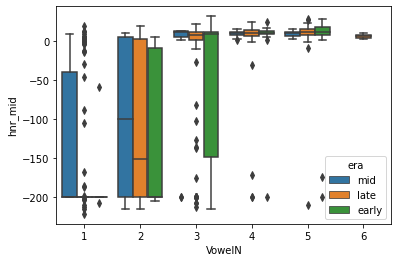

In [30]:
sns.boxplot(data=df, y='hnr_mid', x='VowelN', hue='era')

Yes it is kind of weird! But what does this show us? The super tall boxes are a pretty good representation of where the transition from modal (HNR > 0) and whisper (HNR < 0) occurs. So this boxplot shows us that *when* the transition to whisper does seem to change based on the era. But it's not exactly as predicted -- it's earliest in the early years, and latest in the middle years.

Here's another way to look at it, using a lineplot, which does basically the same thing, but provides a slightly different representation.

<AxesSubplot:xlabel='VowelN', ylabel='hnr_mid'>

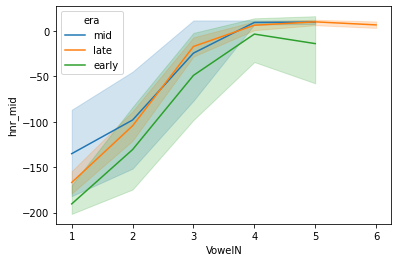

In [29]:
sns.lineplot(data=df, y='hnr_mid', x='VowelN', hue='era')

<AxesSubplot:xlabel='era', ylabel='hnr_mid'>

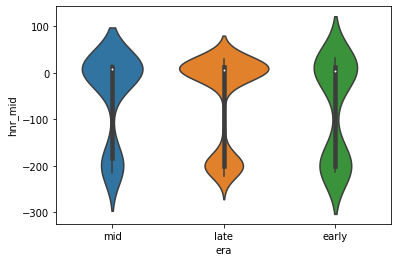

In [39]:
sns.violinplot(data=df, y='hnr_mid', x='era')

**Question 3: does the percentage of whispered vowels per utterance increase across the years?**

`groupby` is a method in `pandas` that summarizes dataframes over some list of factors. Here, we want to keep the recording ID and the era. By taking the mean, we'll create a column with the percentage of whispered vowels for each recording.

In [45]:
df['whisper'] = df.VoiceQ.apply(lambda x: 1 if x=='whisper' else 0) # creates a new column with 1 if the vowel is whispered

In [54]:
percentdf = df.groupby(['recording', 'era']).mean().reset_index()
percentdf.head()

,recording,era,Unnamed: 0,year,VowelN,t1,t2,timetoIPend,hnr_mid,hnr_mean,f0_mid,f0_mean,duration,center,whisper
0,00_04_03_africanos_41,early,2.0,2000.0,3.0,8.369879,8.443402,0.548813,-75.967430,5.193592,172.854783,158.442987,0.073523,8.406640,0.4
1,00_04_03_brevemente_43,early,2.0,2000.0,3.0,9.258807,9.353532,0.440440,-114.848346,2.200656,157.258354,155.734268,0.094725,9.306169,0.4
2,01_02_21_partido_57,early,2.0,2001.0,3.0,10.245894,10.325610,0.426830,-36.986997,8.802807,160.775749,158.924556,0.079716,10.285752,0.2
3,01_02_21_tiempo_58,early,2.0,2001.0,3.0,8.985608,9.060782,0.412318,-76.088004,1.961665,163.385072,164.284063,0.075174,9.023195,0.2
4,01_02_21_varela_56,early,2.0,2001.0,3.0,5.723109,5.821969,0.442112,-30.822957,6.496805,149.585903,150.141700,0.098860,5.772539,0.2


Now we can make a boxplot and look at whether the percentage of whispered vowels change over time. It's hard to tell

<AxesSubplot:xlabel='era', ylabel='whisper'>

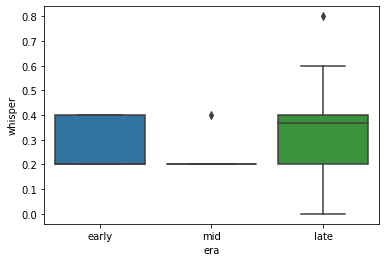

In [55]:
sns.boxplot(data = percentdf, x='era', y='whisper')